In [ ]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')
# 参数与配置
torch.manual_seed(100)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# 修改数据加载部分，添加归一化
def dataloader(batch_size, workers=2):
    # 加载数据
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 数据归一化
    data_mean = train_xdata.mean()
    data_std = train_xdata.std()
    train_xdata = (train_xdata - data_mean) / data_std
    val_xdata = (val_xdata - data_mean) / data_std
    test_xdata = (test_xdata - data_mean) / data_std

    # 转换为Tensor
    train_xdata = torch.FloatTensor(train_xdata)
    train_ylabel = torch.LongTensor(train_ylabel)
    val_xdata = torch.FloatTensor(val_xdata)
    val_ylabel = torch.LongTensor(val_ylabel)
    test_xdata = torch.FloatTensor(test_xdata)
    test_ylabel = torch.LongTensor(test_ylabel)

    # 创建DataLoader
    train_loader = Data.DataLoader(Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

class LSTMclassifier(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.3):
        super().__init__()
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # 构建LSTM层和Dropout层
        for i in range(self.num_layers):
            input_size = input_dim if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_size, hidden_layer_sizes[i], batch_first=True))
            if i < self.num_layers - 1:  # 最后一层后不加Dropout
                self.dropouts.append(nn.Dropout(dropout_rate))
        
        # 初始化LSTM权重
        for lstm in self.lstm_layers:
            for name, param in lstm.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_normal_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # 调整输入形状，检查是否可整除
        if input_seq.shape[1] == 1024:  # 假设原始数据长度为1024
            input_seq = input_seq.view(batch_size, 32, 32)
        else:
            raise ValueError("输入数据长度不符合reshape要求")
        
        lstm_out = input_seq
        for i in range(self.num_layers):
            lstm_out, _ = self.lstm_layers[i](lstm_out)
            if i < self.num_layers - 1:
                lstm_out = self.dropouts[i](lstm_out)
        
        return self.classifier(lstm_out[:, -1, :])

# 参数设置
input_dim = 32
#hidden_layer_sizes = [256, 128, 64]
hidden_layer_sizes = [128, 64, 32]
output_dim = 5
batch_size = 64
epochs = 50

# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

# 初始化模型
model = LSTMclassifier(input_dim, hidden_layer_sizes, output_dim).to(device)

# 损失函数和优化器
loss_function = nn.CrossEntropyLoss(reduction='mean')  # 使用mean
learn_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

# 训练函数
def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    best_accuracy = 0.0
    train_loss, train_acc = [], []
    validate_loss, validate_acc = [], []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(seq)
            loss = loss_function(outputs, labels)
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item() * seq.size(0)
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
        
        # 计算训练指标
        epoch_loss = total_loss / len(train_loader.dataset)
        epoch_acc = correct / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                outputs = model(seq)
                val_loss += loss_function(outputs, labels).item() * seq.size(0)
                preds = torch.argmax(outputs, 1)
                val_correct += (preds == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        validate_loss.append(val_loss)
        validate_acc.append(val_acc)
        
        # 保存最佳模型
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model, 'best_model-lstm.pt')
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')
    
    # 绘制曲线
    #plt.figure(figsize=(12,5))
    #plt.subplot(121)
    #plt.plot(train_loss, label='Train Loss')
    #plt.plot(validate_loss, label='Val Loss')
    #plt.legend()
    #plt.subplot(122)
    #plt.plot(train_acc, label='Train Acc')
    #plt.plot(validate_acc, label='Val Acc')
    #plt.legend()
    #plt.show()

    #print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 

    def count_parameters(model):
        params = [p.numel() for p in model.parameters() if p.requires_grad]
        for item in params:
            print(f'{item:>6}')
        print(f'______\n{sum(params):>6}')
        print(f'Best Validation Accuracy: {best_accuracy:.4f}')
    count_parameters(model)
# 开始训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)


Epoch 1/50
Train Loss: 1.3738 Acc: 0.3222
Val Loss: 1.0630 Acc: 0.4135

Epoch 2/50
Train Loss: 0.8989 Acc: 0.5515
Val Loss: 0.7467 Acc: 0.5806

Epoch 3/50
Train Loss: 0.7388 Acc: 0.5894
Val Loss: 0.6660 Acc: 0.5821

Epoch 4/50
Train Loss: 0.6911 Acc: 0.6116
Val Loss: 0.6816 Acc: 0.5885

Epoch 5/50
Train Loss: 0.6583 Acc: 0.6283
Val Loss: 0.6263 Acc: 0.6491

Epoch 6/50
Train Loss: 0.6333 Acc: 0.6519
Val Loss: 0.5582 Acc: 0.6848

Epoch 7/50
Train Loss: 0.5535 Acc: 0.7324
Val Loss: 0.4840 Acc: 0.7527

Epoch 8/50
Train Loss: 0.4793 Acc: 0.7926
Val Loss: 0.3555 Acc: 0.8495

Epoch 9/50
Train Loss: 0.3729 Acc: 0.8682
Val Loss: 0.2772 Acc: 0.8803

Epoch 10/50
Train Loss: 0.2671 Acc: 0.9144
Val Loss: 0.1769 Acc: 0.9145

Epoch 11/50
Train Loss: 0.2128 Acc: 0.9307
Val Loss: 0.2011 Acc: 0.9125

Epoch 12/50
Train Loss: 0.1969 Acc: 0.9331
Val Loss: 0.2008 Acc: 0.9154

Epoch 13/50
Train Loss: 0.1611 Acc: 0.9457
Val Loss: 0.1816 Acc: 0.9174

Epoch 14/50
Train Loss: 0.1625 Acc: 0.9476
Val Loss: 0.1779 

In [3]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')
# 参数与配置
torch.manual_seed(100)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
class LSTMclassifier(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes, output_dim, dropout_rate=0.3):
        super().__init__()
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # 构建LSTM层和Dropout层
        for i in range(self.num_layers):
            input_size = input_dim if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_size, hidden_layer_sizes[i], batch_first=True))
            if i < self.num_layers - 1:  # 最后一层后不加Dropout
                self.dropouts.append(nn.Dropout(dropout_rate))
        
        # 初始化LSTM权重
        for lstm in self.lstm_layers:
            for name, param in lstm.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_normal_(param)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )

    def forward(self, input_seq):
        batch_size = input_seq.size(0)
        # 调整输入形状，检查是否可整除
        if input_seq.shape[1] == 1024:  # 假设原始数据长度为1024
            input_seq = input_seq.view(batch_size, 32, 32)
        else:
            raise ValueError("输入数据长度不符合reshape要求")
        
        lstm_out = input_seq
        for i in range(self.num_layers):
            lstm_out, _ = self.lstm_layers[i](lstm_out)
            if i < self.num_layers - 1:
                lstm_out = self.dropouts[i](lstm_out)
        
        return self.classifier(lstm_out[:, -1, :])

In [4]:
# 定义模型参数
input_dim = 32   # 输入维度为一维信号序列堆叠为  32 * 32
#hidden_layer_sizes = [256, 128, 64]  # LSTM 层数， 每层 神经元个数
hidden_layer_sizes = [128, 64, 32]  # LSTM 层数， 每层 神经元个数
output_dim = 5

model = LSTMclassifier(input_dim, hidden_layer_sizes, output_dim)  
# 定义损失函数和优化函数 

loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

 16384
 65536
   512
   512
 32768
 16384
   256
   256
  8192
  4096
   128
   128
  2048
    64
   320
     5
______
147589


In [5]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# 模型 测试集 验证  
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练
device = torch.device("cpu") # 有GPU先用GPU训练
# 得出每一类的分类准确率
model = torch.load('best_model-lstm.pt')best_model-lstm

model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17304\3352204684.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model-lstm.pt')


NameError: name 'test_loader' is not defined

In [6]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()

NameError: name 'confusion_mat' is not defined

<Figure size 3000x2400 with 0 Axes>

In [9]:
import torch
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model-lstm.pt')#best_model-lstm
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17304\3773530014.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model-lstm.pt')#best_model-

NameError: name 'test_loader' is not defined

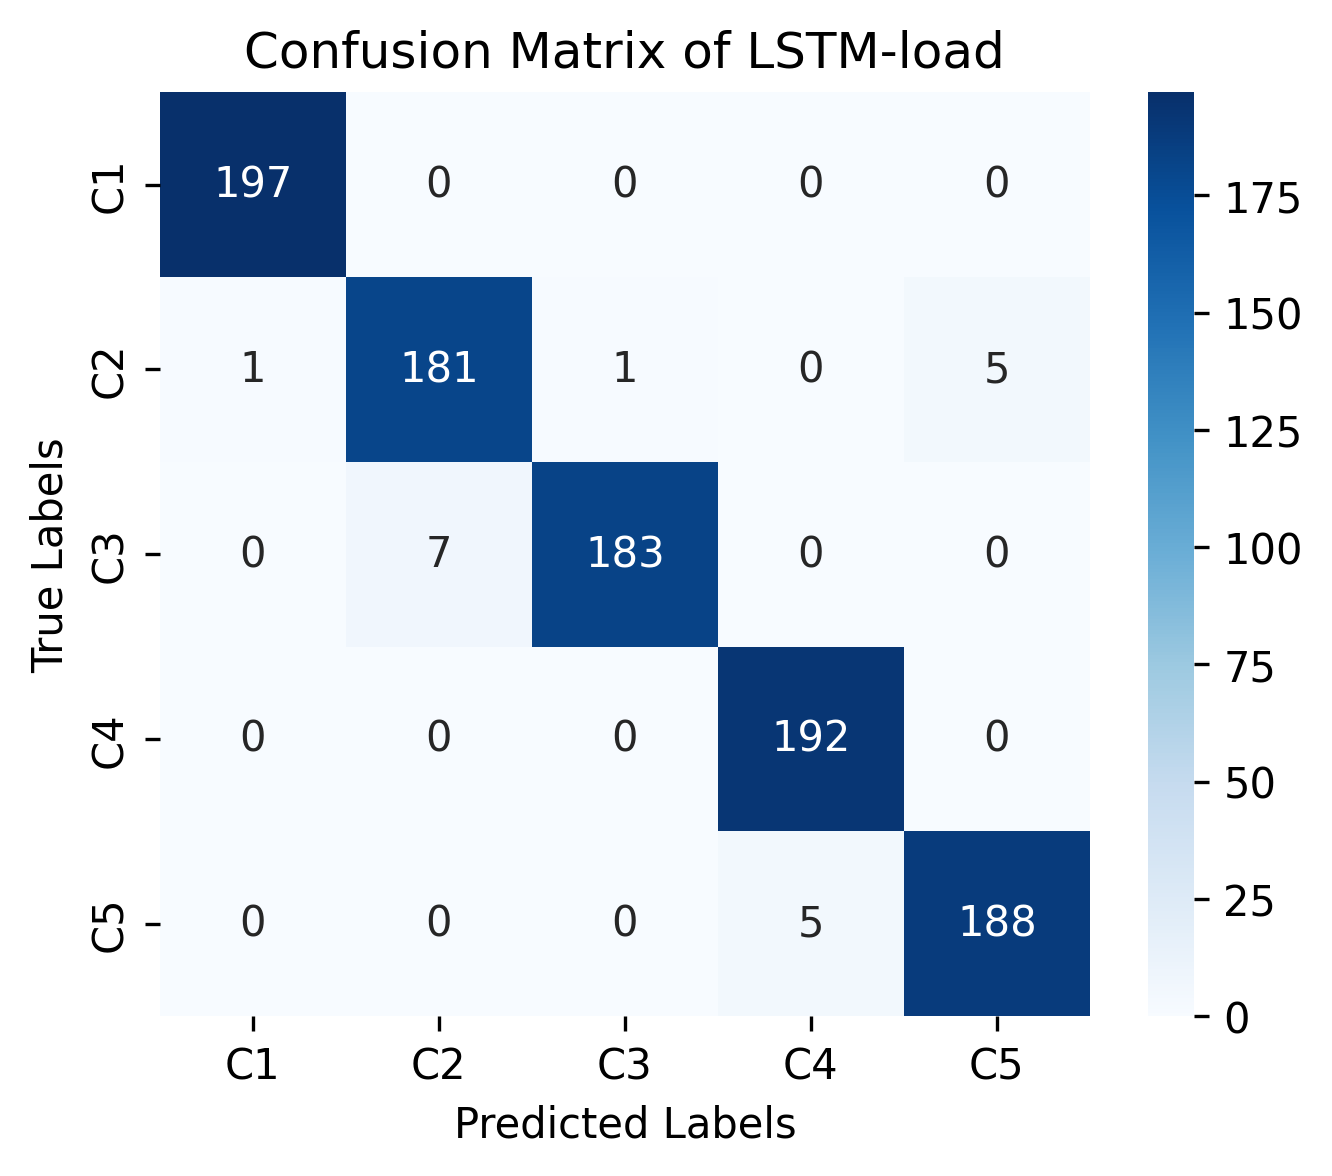

In [39]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    #5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of LSTM-load')
plt.savefig("LSTM_confusion.png")
plt.show()